In [1]:
import numpy as np 
import pandas as pd 
import itertools
import fnmatch
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from glob import glob
from skimage import io
from os import listdir
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import History
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import pickle
from keras.models import load_model
from tensorflow.keras import layers

Using TensorFlow backend.


In [2]:
imagePatches = glob('./breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

./breast-histopathology-images/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1001_class0.png
./breast-histopathology-images/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1051_class0.png
./breast-histopathology-images/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1101_class0.png
./breast-histopathology-images/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1151_class0.png
./breast-histopathology-images/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1201_class0.png
./breast-histopathology-images/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1251_class0.png
./breast-histopathology-images/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1301_class0.png
./breast-histopathology-images/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1351_class0.png
./breast-histopathology-images/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1501_class0.png
./breast-histopathology-images/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1551_class0.png


In [3]:
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero)
classOne = fnmatch.filter(imagePatches, patternOne)
print("IDC(-)\n\n",classZero[0:5],'\n')
print("IDC(+)\n\n",classOne[0:5])

IDC(-)

 ['./breast-histopathology-images/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1001_class0.png', './breast-histopathology-images/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1051_class0.png', './breast-histopathology-images/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1101_class0.png', './breast-histopathology-images/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1151_class0.png', './breast-histopathology-images/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1201_class0.png'] 

IDC(+)

 ['./breast-histopathology-images/IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x501_y351_class1.png', './breast-histopathology-images/IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x501_y401_class1.png', './breast-histopathology-images/IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x551_y301_class1.png', './breast-histopathology-images/IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x551_y351_class1.png', './breast-histopathology-images/IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x

In [4]:
def proc_images(lowerIndex,upperIndex):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    x = []
    y = []
    WIDTH = 50
    HEIGHT = 50
    for img in imagePatches[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

In [5]:
X,Y = proc_images(0,75000)
df = pd.DataFrame()
df["images"]=X
df["labels"]=Y
X2=df["images"]
Y2=df["labels"]
X2=np.array(X2)
imgs0=[]
imgs1=[]
imgs0 = X2[Y2==0] # (0 = no IDC, 1 = IDC)
imgs1 = X2[Y2==1] 

In [6]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X2,Y2)

Total number of images: 75000
Number of IDC(-) Images: 54099
Number of IDC(+) Images: 20901
Percentage of positive images: 27.87%
Image shape (Width, Height, Channels): (50, 50, 3)


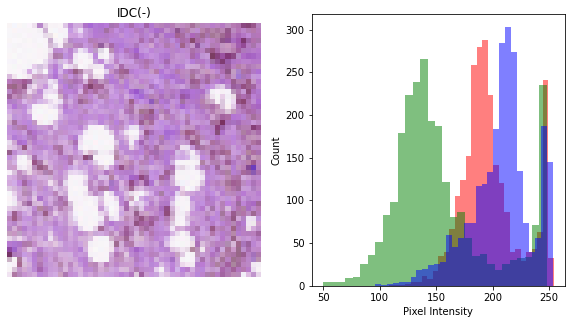

In [33]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    plt.title('IDC(+)' if Y[1] else 'IDC(-)')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X2[100])

In [7]:
X=np.array(X)
X=X/255.0

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=1984)

# Reduce Sample Size for DeBugging
X_train = X_train[0:75000] 
Y_train = Y_train[0:75000]
X_test = X_test[0:75000] 
Y_test = Y_test[0:75000]

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (67500, 50, 50, 3)
Testing Data Shape: (7500, 50, 50, 3)


In [49]:
from tensorflow.keras import layers
model = keras.Sequential()
model.add(keras.Input(shape=(50, 50, 3)))  
model.add(layers.Conv2D(32, 5, strides=2, activation="relu"))
model.add(layers.Conv2D(32, 3, activation="relu"))
model.add(layers.MaxPooling2D(3))
model.summary()



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 23, 23, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
Total params: 11,680
Trainable params: 11,680
Non-trainable params: 0
_________________________________________________________________


In [55]:
model = keras.Sequential()
model.add(keras.Input(shape=(50,50,3)))
model.add(layers.Conv2D(32,5, strides=2, activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(.25))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 23, 23, 32)        2432      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               819328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)             

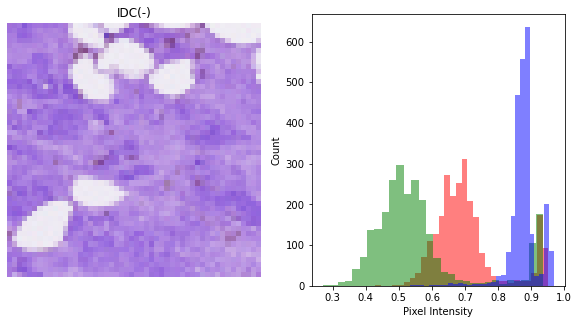

In [11]:
plotHistogram(X_train[10])

In [35]:
# convert labels to categorical features
Y_trainHot = to_categorical(Y_train, num_classes = 2)
Y_testHot = to_categorical(Y_test, num_classes = 2)

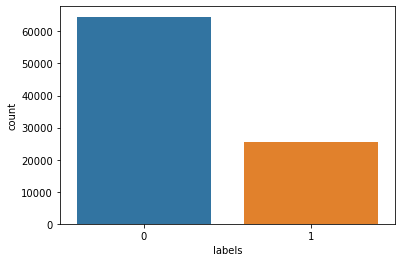

In [53]:
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)


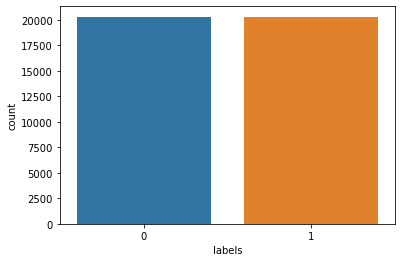

In [37]:
#got help from https://www.kaggle.com/paultimothymooney/predict-idc-in-breast-cancer-histology-images 
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
#print("X_train Shape: ",X_train.shape)
#print("X_test Shape: ",X_test.shape)
#print("X_trainFlat Shape: ",X_trainFlat.shape)
#print("X_testFlat Shape: ",X_testFlat.shape)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
#ros = RandomOverSampler(ratio='auto')
ros = RandomUnderSampler(random_state=42)
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 2)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 2)
#print("X_train: ", X_train.shape)
#print("X_trainFlat: ", X_trainFlat.shape)
#print("X_trainRos Shape: ",X_trainRos.shape)
#print("X_testRos Shape: ",X_testRos.shape)
#print("Y_trainRosHot Shape: ",Y_trainRosHot.shape)
#print("Y_testRosHot Shape: ",Y_testRosHot.shape)

for i in range(len(X_trainRos)):
    height, width, channels = 50,50,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
#print("X_trainRos Shape: ",X_trainRos.shape)
#print("X_trainRosReshaped Shape: ",X_trainRosReshaped.shape)

for i in range(len(X_testRos)):
    height, width, channels = 50,50,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
#print("X_testRos Shape: ",X_testRos.shape)
#print("X_testRosReshaped Shape: ",X_testRosReshaped.shape)

dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)


In [63]:
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}

In [38]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
print("Old Class Weights: ",class_weight)
from sklearn.utils import class_weight
class_weight2 = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
print("New Class Weights: ",class_weight2)

Old Class Weights:  [0.69632495 1.77339901]
New Class Weights:  [1. 1.]


In [61]:
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(12,8))
    metrics = np.load('logs.npy', allow_pickle=True)[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

Epoch 1/8
1269/1268 [==============================] - 65s 51ms/step - loss: 0.6925 - accuracy: 0.5244 - val_loss: 0.6753 - val_accuracy: 0.5817
Epoch 2/8
1269/1268 [==============================] - 55s 44ms/step - loss: 0.6813 - accuracy: 0.5582 - val_loss: 0.6642 - val_accuracy: 0.6583
Epoch 3/8
1269/1268 [==============================] - 55s 44ms/step - loss: 0.6712 - accuracy: 0.5865 - val_loss: 0.6491 - val_accuracy: 0.6896
Epoch 4/8
1269/1268 [==============================] - 57s 45ms/step - loss: 0.6583 - accuracy: 0.6188 - val_loss: 0.6354 - val_accuracy: 0.6992
Epoch 5/8
1269/1268 [==============================] - 56s 44ms/step - loss: 0.6461 - accuracy: 0.6425 - val_loss: 0.6237 - val_accuracy: 0.6992
Epoch 6/8
1269/1268 [==============================] - 58s 46ms/step - loss: 0.6349 - accuracy: 0.6566 - val_loss: 0.6071 - val_accuracy: 0.7091
Epoch 7/8
1269/1268 [==============================] - 58s 46ms/step - loss: 0.6220 - accuracy: 0.6717 - val_loss: 0.5947 - val_ac

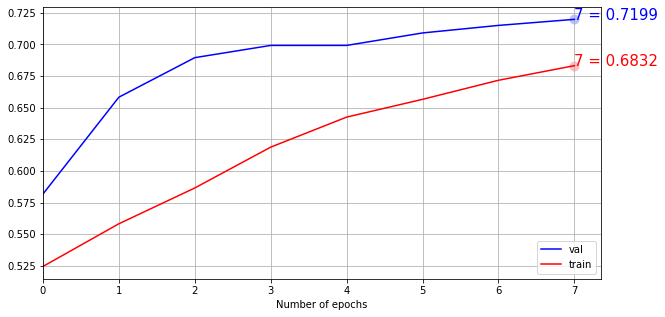

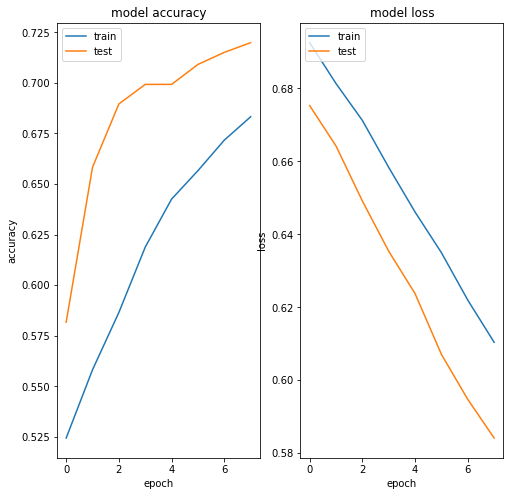

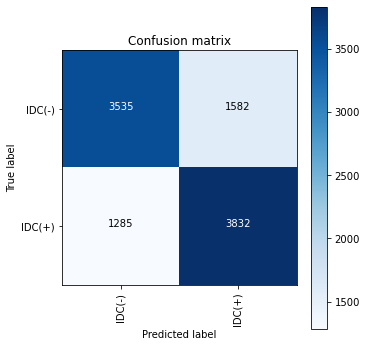

In [64]:
def runKerasCNNAugment(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 128
    num_classes = 2
    epochs = 8
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs,class_weight=f, validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNNAugment(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

Training set: X = (67500, 50, 50, 3), y = (67500, 2)
Testing set: X = (7500, 50, 50, 3), y = (7500, 2)


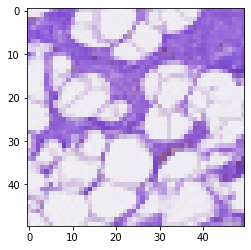

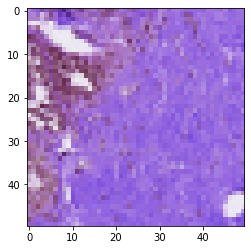

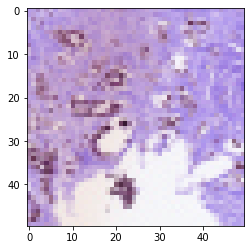

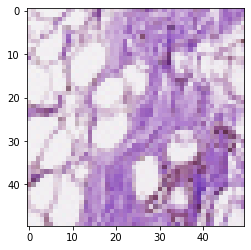

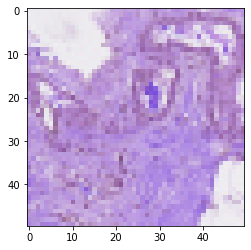

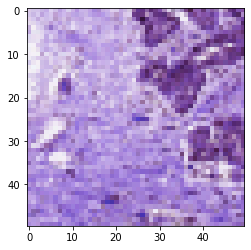

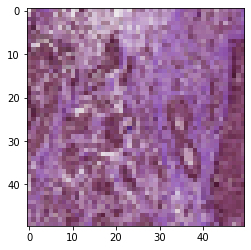

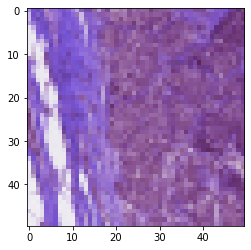

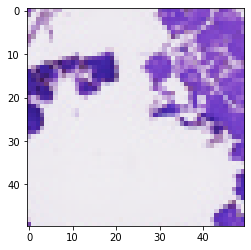

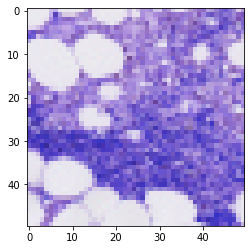

In [21]:
print(f'Training set: X = {X_train.shape}, y = {Y_train.shape}')
print(f'Testing set: X = {X_test.shape}, y = {Y_test.shape}')
# plot first few images
for i in range(10):
    plt.imshow(X_train[i], cmap = plt.get_cmap('gray'))
    print(f'{yhat_probs[i]}')
    plt.show()